**Setup:**

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'drive/My Drive/Anomaly Detection'

In [ ]:
!pip install pykeops

In [ ]:
#imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import os
#https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy
#https://stackoverflow.com/questions/49290266/python-matplotlib-histogram-specify-different-colours-for-different-bars

In [ ]:
#https://colab.research.google.com/drive/1RacHDFpDvKPxN4brmGMnEY2454CW_Dds#scrollTo=QuOkHYcjU331
#get data
trans = transforms.Compose([    transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ]) #grayscale and to [0,1]
train_data = datasets.MNIST('.', train=True, download=True, transform=trans)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)


In [ ]:
#check that loader gives correct dimensions
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_data[0].shape)

torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])


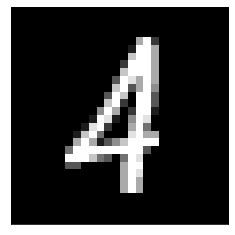

In [ ]:
#return figure object that displays the given image
def show_digit(img):
  fig = plt.figure()
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

f = show_digit(example_data[63][0])
f

**Autoencoder model:**

In [ ]:
#https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
#https://www.datacamp.com/community/tutorials/autoencoder-classifier-python
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    #encode
    #input is 1 x 28 x 28
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32,3, padding=1),  #32 x 28 x 28
        nn.ReLU(),
        nn.MaxPool2d(2,2) #32 x 14 x 14
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,16,3, padding=1), #16 x 14 x 14 
        nn.ReLU(),
        nn.MaxPool2d(2,2) #16 x 7 x 7
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(16,8,3, padding=1),  #8 x 7 x 7
        nn.ReLU(),
        nn.Conv2d(8,8,3, padding=1), #8 x 7 x 7
        nn.ReLU()
    )
    #decode
    self.layer4 = nn.Sequential(
        nn.Conv2d(8,8,3, padding=1), #8 x 7 x 7
        nn.ReLU()
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(8,8,3, padding=1),  #8 x 7 x 7
        nn.ReLU(),
        nn.Upsample(scale_factor=2) #8 x 14 x 14
    )
    self.layer6 = nn.Sequential(
        nn.Conv2d(8,8,3, padding=1), #8 x 14 x 14
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  #8 x 28 x 28
        nn.Conv2d(8,1,3, padding=1) #1 x 28 x 28
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)

    return out

  #to extract latent layers later
  def extract_latent(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)

    return out

  def extract_all(self, x):
    res = []
    out = self.layer1(x)
    res.append(out)
    out = self.layer2(out)
    res.append(out)
    out = self.layer3(out)
    res.append(out)
    out = self.layer4(out)
    res.append(out)
    out = self.layer5(out)
    res.append(out)
    
    return res



**Training for Reconstruction**


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(device.type == "cuda"):
  print("Training on GPU")
else:
  print("Training on CPU")
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
'''
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001
'''
losses = []
i = 0
for epoch in range(5):
  i+=1
  for images, labels in trainloader:
    if(device.type == "cuda"):  #convert from torch.floattensor to torch.cuda.floattensor
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images) #loss based on similarity to input
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch {}/{}, Loss: {:.6f}'.format(i, 5, loss.item()))



**Plot for Loss**

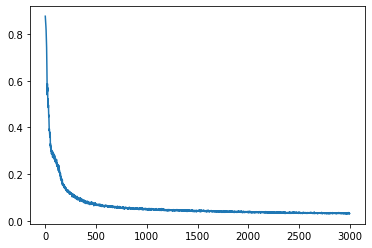

In [ ]:
plt.plot(range(3000), losses)

torch.Size([28, 28])


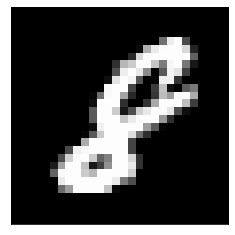

In [ ]:
d = enumerate(trainloader)
idx, (img, label) = next(d)
print(img[0][0].shape)
show_digit(img[0][0])

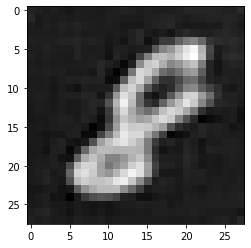

In [ ]:
#tensor gymnastics in order predict a single sample
plt.imshow(model(img[0].view(-1,1,28,28).cuda()).cpu().detach().numpy()[0][0], cmap=plt.get_cmap('gray'))

**Anomaly Detection**

In [ ]:
test_data = datasets.MNIST('.', train=False, download=True, transform=trans)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [ ]:
mses = []
for epoch in range(5):
  for images, labels in testloader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())

(array([  2.,   8.,  25.,  54., 117., 117.,  96.,  57.,  19.,   5.]),
 array([0.0274684 , 0.02813943, 0.02881045, 0.02948148, 0.03015251,
        0.03082353, 0.03149456, 0.03216558, 0.03283661, 0.03350764,
        0.03417866]),
 <a list of 10 Patch objects>)

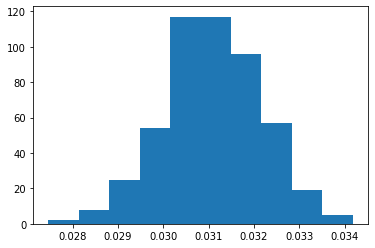

In [ ]:
plt.hist(mses)#, range=[0.01,0.018])

In [ ]:
from scipy.io import loadmat
p = 'drive/My Drive/Anomaly Detection/'
garbage_mats = []
#x = loadmat('drive/My Drive/Anomaly Detection/BD0_201-300.mat')
mats = [file for file in os.listdir(p) if '.mat' in file]
for f in mats:
  for img_arr in loadmat(p+f)['images']:
    for img in img_arr:
      #print(img.shape)
      garbage_mats.append(np.array(Image.fromarray(img, 'L').resize((28,28))))  #in order to view garbage_mats[i] --> Image.fromarray(garbage_mats[i]*255) as pixel intensity is low

In [ ]:
Image.fromarray(garbage_mats[120]*255)

In [ ]:
'''#Load garbage tiffs
garbage = []
gimgs = []
p = 'drive/My Drive/Anomaly Detection/'
"""garbage.append(torch.from_numpy(np.array(Image.open('drive/My Drive/Anomaly Detection/Garbage3.tiff').convert('L').resize((28,28)))).float().to(device)/255)
gimgs.append(Image.open('drive/My Drive/Anomaly Detection/Garbage3.tiff').convert('L').resize((28,28)))

for i in range(9,14):
  p = 'drive/My Drive/Anomaly Detection/Garbage' + str(i) + '.tiff'
  garbage.append(torch.from_numpy(np.array(Image.open(p).convert('L').resize((28,28)))).float().to(device)/255)
  gimgs.append(Image.open(p).convert('L').resize((28,28)))"""

gfiles = [file for file in os.listdir(p) if '.tiff' in file]
for file in gfiles:
  garbage.append(torch.from_numpy(np.array(Image.open(p+file).convert('L').resize((28,28)))).float().to(device)/255)
  gimgs.append(Image.open(p+file).convert('L').resize((28,28)))'''

'#Load garbage tiffs\ngarbage = []\ngimgs = []\np = \'drive/My Drive/Anomaly Detection/\'\n"""garbage.append(torch.from_numpy(np.array(Image.open(\'drive/My Drive/Anomaly Detection/Garbage3.tiff\').convert(\'L\').resize((28,28)))).float().to(device)/255)\ngimgs.append(Image.open(\'drive/My Drive/Anomaly Detection/Garbage3.tiff\').convert(\'L\').resize((28,28)))\n\nfor i in range(9,14):\n  p = \'drive/My Drive/Anomaly Detection/Garbage\' + str(i) + \'.tiff\'\n  garbage.append(torch.from_numpy(np.array(Image.open(p).convert(\'L\').resize((28,28)))).float().to(device)/255)\n  gimgs.append(Image.open(p).convert(\'L\').resize((28,28)))"""\n\ngfiles = [file for file in os.listdir(p) if \'.tiff\' in file]\nfor file in gfiles:\n  garbage.append(torch.from_numpy(np.array(Image.open(p+file).convert(\'L\').resize((28,28)))).float().to(device)/255)\n  gimgs.append(Image.open(p+file).convert(\'L\').resize((28,28)))'

In [ ]:
'''plt.tight_layout()
for im in gimgs:
  plt.figure()
  plt.imshow(im, cmap=plt.get_cmap('gray'))'''

"plt.tight_layout()\nfor im in gimgs:\n  plt.figure()\n  plt.imshow(im, cmap=plt.get_cmap('gray'))"

In [ ]:
#mats -> torch tensors
garbage = [torch.from_numpy(img).float().to(device) for img in garbage_mats]

#resize garbage images to proper input dimensions (1 x 28 x 28)
#add a dimension as pytorch expects one
for i in range(len(garbage)):
  garbage[i] = garbage[i].view(1,1,28,28)

In [ ]:
len(garbage)

451

In [ ]:
for i in range(len(garbage)):
  o = model(garbage[i])
  loss = criterion(o,garbage[i])
  mses.append(loss.item())

**In the plot below we see the real sample MSEs (blue) as well as the garbage sample MSEs (orange)**

(array([ 11.,  54., 115., 132.,  76.,  31.,  20.,   9.,   1.,   2.]),
 array([0.17423676, 0.20552381, 0.23681086, 0.26809791, 0.29938495,
        0.330672  , 0.36195905, 0.3932461 , 0.42453315, 0.4558202 ,
        0.48710725]),
 <a list of 10 Patch objects>)

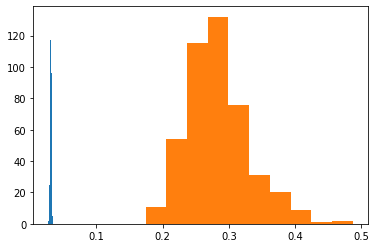

In [ ]:
plt.hist(mses[:len(mses)-len(garbage)])
plt.hist(mses[len(mses)-len(garbage):])
#mses[len(mses)-len(garbage):]

In [ ]:
print("Real Loss Range: " + str(min(mses[:len(mses)-len(garbage)])) + " - " + str(max(mses[:len(mses)-len(garbage)])))
print("Garbage Loss Range: " + str(min(mses[len(mses)-len(garbage):])) + " - " + str(max(mses[len(mses)-len(garbage):])))

Real Loss Range: 0.027468401938676834 - 0.03417866304516792
Garbage Loss Range: 0.17423675954341888 - 0.4871072471141815


In [ ]:
#ideal separation: if we considered the true sets of inliers and outliers
c = mses[:len(mses)-len(garbage)]
o = mses[len(mses)-len(garbage):]
c_avg = sum(c) / len(c)
c_var = sum((x-c_avg)**2 for x in c) / len(c)
o_avg = sum(o) / len(o)
o_var = sum((x-o_avg)**2 for x in o) / len(o)

ideal_separation = (c_avg - o_avg)**2 / (c_var + o_var)

#separatation after applying a threshold
threshold = 0.05
n_out_rejected = 0
n_in_rejected = 0
inliers, outliers = [], []

for i in range(len(mses)):
  if mses[i] > threshold:
    outliers.append(mses[i])
    if i < len(mses)-len(garbage):
      n_in_rejected += 1
    else:
      n_out_rejected += 1
  else:
    inliers.append(mses[i])

in_avg = sum(inliers) / len(inliers)
in_var = sum((x-in_avg)**2 for x in inliers) / len(inliers)
ot_avg = sum(outliers) / len(outliers)
ot_var = sum((x-ot_avg)**2 for x in outliers) / len(outliers)

separation = (in_avg - ot_avg)**2 / (in_var + ot_var)

print("IDEAL SEPARATION: " + str(ideal_separation))
print("SEPARATION: " + str(separation))
print("% Outliers Rejected: " + str(n_out_rejected/len(o)))
print("% Inliers Rejected: " + str(n_in_rejected/len(c)))

IDEAL SEPARATION: 29.013783958110515
SEPARATION: 29.013783958110515
% Outliers Rejected: 1.0
% Inliers Rejected: 0.0


The above histogram shows how distinct the error readings for garbage samples (orange) are from real data (blue), making it simple to identify outliers.

**Latent Variable Analysis**

In [ ]:
#100 batches of 100 outputs w/ 256x7x7 shape
latent_var_testset = []
for images, labels in testloader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    latent_var_testset.append(model.extract_latent(images))

In [ ]:
latent_vars = []
for i in range(len(latent_var_testset)):
  for j in range(100):
    latent_vars.append(torch.flatten(latent_var_testset[i][j]))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
for i in range(len(latent_vars)):
  latent_vars[i] = latent_vars[i].cpu().detach().numpy()

lv = np.array(latent_vars)

In [ ]:
#get latent vars for garbage values
glv = []
for i in range(len(garbage)):
  glv.append(torch.flatten(model.extract_latent(garbage[i])))

for i in range(len(glv)):
  glv[i] = glv[i].cpu().detach().numpy()

glv = np.array(glv)

In [ ]:
kmeans = KMeans(n_clusters=5).fit(lv)

In [ ]:
lv.shape

(10000, 392)

In [ ]:
from scipy.spatial import distance

In [ ]:
#compute distance to closest cluster center for real and garbage examples
real_distances = []
centers = kmeans.cluster_centers_
for i in range(len(lv)):
  d = []
  for j in range(len(centers)):
    d.append(distance.euclidean(centers[j], lv[i]))

  real_distances.append(min(d))

garbage_distances = []
for i in range(len(glv)):
  d = []
  for j in range(len(centers)):
    d.append(distance.euclidean(centers[j], glv[i]))

  garbage_distances.append(min(d))

Below is the histogram of distances from the nearest centroid for each data point measured, including garbage values. The garbage values are in red, clearly distinct from the main distribution of distance values.

(array([ 41000., 169000., 117000.,  57000.,  22000.,  21000.,  10000.,
          7000.,   5000.,   2000.]),
 array([40.29502487, 40.80113106, 41.30723724, 41.81334343, 42.31944962,
        42.8255558 , 43.33166199, 43.83776817, 44.34387436, 44.84998055,
        45.35608673]),
 <a list of 10 Patch objects>)

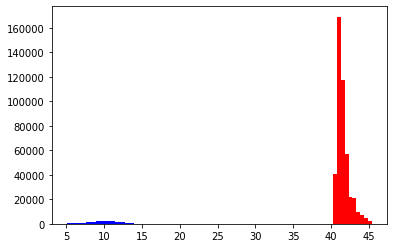

In [ ]:
fig, ax = plt.subplots()
N, bins, patches = ax.hist(real_distances, color='blue')
ax.hist(garbage_distances*1000, color='red')  #multiplied the list by 1000 in order to show on graph - low frequency of each value is due to the small set of garbage data

In [ ]:
#clear some gpu memory for following operations
del latent_var_testset
torch.cuda.empty_cache()

**Layer By Layer Analysis**

Here we cluster points based on the vectors produced at each layer and plot only the lowest distance for each example from the nearest centroid for each layer.

In [ ]:
real_all_layers = []
for images, labels in testloader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    real_all_layers.append(model.extract_all(images))

In [ ]:
lyrs = [[],[],[],[],[]]
for i in range(len(real_all_layers)):
  for j in range(len(real_all_layers[i])):
    lyrs[j].append(torch.flatten(real_all_layers[i][j]).cpu().detach().numpy())

In [ ]:
for i in range(len(lyrs)):
  lyrs[i] = np.array(lyrs[i])

In [ ]:
lyrs[0].shape

(100, 627200)

In [ ]:
kmean = []
for i in range(len(lyrs)):
  k = KMeans(n_clusters=5).fit(lyrs[i])
  kmean.append(k)

In [ ]:
#get layers for garbage images
gly = []
for i in range(len(garbage)):
  t = model.extract_all(garbage[i])
  for j in range(len(t)):
    t[j] = torch.flatten(t[j]).cpu().detach().numpy()
  gly.append(t)
#6,5,x

In [ ]:
def dist(lyrs, centers):
  distances = []
  for i in range(len(lyrs)):
    d = []
    for j in range(len(centers)):
      d.append(distance.euclidean(centers[j], lyrs[i]))

    distances.append(min(d))
  return distances

In [ ]:
real_min_dists = []
for i in range(len(real_all_layers)):
  l_d = []
  
  for lyr in range(len(real_all_layers[i])):
    lyrdist = []
    
    for j in range(len(kmean[lyr].cluster_centers_)):
      lyrdist.append(distance.euclidean(torch.flatten(real_all_layers[i][lyr]).cpu().detach().numpy(), kmean[lyr].cluster_centers_[j]))  #concat to list  
    
    l_d.append(min(lyrdist))
  
  real_min_dists.append(min(l_d))

In [ ]:
garbage_min_dists = []
for i in range(len(gly)):
  l_d = []
  for lyr in range(len(gly[i])):
    l_d = l_d + (dist(gly[i][lyr], kmean[lyr].cluster_centers_))
  garbage_min_dists.append(min(l_d))

Above we clustered the values in each layer for each real image, then we computed the distances from the closest centroid for each layer for each real and garbage image. We plotted the smallest of these distances for each image below.

As the spread of the garbage values was not large it did not appear on the histogram, a more clear visual is the scatterplot below.

The real values are in blue and the garbage values are in red.

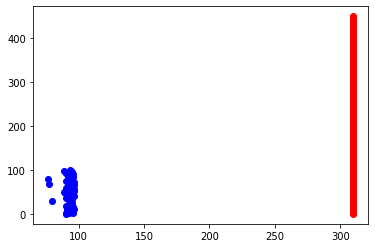

In [ ]:
plt.scatter(garbage_min_dists,range(0,len(garbage_min_dists)), color="red")
plt.scatter(real_min_dists, range(0, len(real_min_dists)), color="blue")